In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys

plt.rcParams['image.cmap'] = 'Blues'
imageFile = "test.fits"
imageAGN = fits.getdata(imageFile)

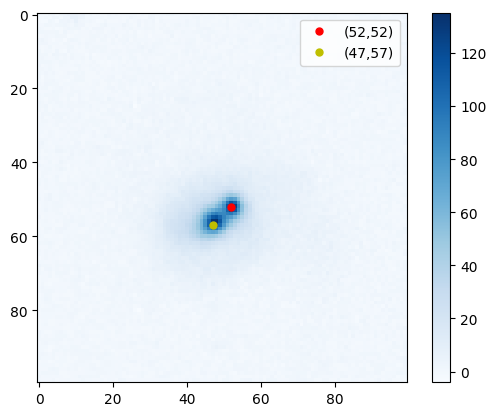

In [2]:
plt.imshow(imageAGN)
plt.plot(52,52,"ro",markersize=5,label="(52,52)")
plt.plot(47,57,"yo",markersize=5,label="(47,57)")
plt.colorbar()
plt.legend();

In [47]:
def galaxy_model(X0, Y0, X1, Y1, Xss, Yss, Xlim, Ylim,
                 PA0, ell0, I0, sigma0, 
                 PA1, ell1, I1, sigma1,
                 PA_ss, ell_ss, n_ss, I_ss, r_ss,
                 PA_lim, ell_lim, I_lim, sigma_lim,
                 gs=False, ggs=False, gsgs=False, gsgss=False):
    """create galaxy model for ML fit
        including: gs: 1 gaussian + 1 sersic
                   ggs: 2 gaussians + 1 sersic
                   gsgs: 2 (gaussian+sersic)
                   gsgss: 2 (gaussian+sersic) + sersic """
    
    gaus0 = {'PA': [PA0, PA_lim[0],PA_lim[1]], 'ell': [ell0, ell_lim[0],ell_lim[1]], 
    'I_0': [I0, I_lim[0],I_lim[1]], 'sigma': [sigma0, sigma_lim[0],sigma_lim[1]]}
    gaus0_dict = {'name': "Gaussian", 'label': "gaus0", 'parameters': gaus0}

    gaus1 = {'PA': [PA1, PA_lim[0],PA_lim[1]], 'ell': [ell1, ell_lim[0],ell_lim[1]], 
    'I_0': [I1, I_lim[0],I_lim[1]], 'sigma': [sigma1,sigma_lim[0],sigma_lim[1]]}
    gaus1_dict = {'name': "Gaussian", 'label': "gaus1", 'parameters': gaus1}

    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 0.5,10],
    'I_e': [I_ss, 0 ,I_lim[1]], 'r_e': [r_ss, 0.0, 10*r_ss]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}


    funcset_dict_gaus0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [gaus0_dict]}
    
    funcset_dict_gaus0_sersic = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [gaus0_dict,sersic_dict]}
    
    funcset_dict_gaus1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1,Ylim[0],Ylim[1]], 
                    'function_list': [gaus1_dict]}
    
    funcset_dict_gaus1_sersic = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1,Ylim[0],Ylim[1]], 
                    'function_list': [gaus1_dict, sersic_dict]}

    funcset_dict_sersic = {'X0': [Xss,Xlim[0],Xlim[1]], 'Y0': [Yss,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}

    model_dict_gs = {'function_sets': [funcset_dict_gaus0_sersic]}
    model_dict_ggs= {'function_sets': [funcset_dict_gaus0, funcset_dict_gaus1,funcset_dict_sersic]}
    model_dict_gsgs = {'function_sets': [funcset_dict_gaus0_sersic, funcset_dict_gaus1_sersic]}
    model_dict_gsgss = {'function_sets': [funcset_dict_gaus0_sersic, funcset_dict_gaus1_sersic,funcset_dict_sersic]}
        
    model_gs = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_gs)
    model_ggs = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ggs)
    model_gsgs = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_gsgs)
    model_gsgss = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_gsgss)
    return model_gs, model_ggs, model_gsgs, model_gsgss


def find_highest_indices(arr):
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def doFit(models): 
    """do fit and return fitters, best fit params, and labels"""
    fitters = []
    bestfits = []
    for i in range(len(models)):
        imfit_fitter = pyimfit.Imfit(models[i])
        imfit_fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        p_bestfit = imfit_fitter.doFit().params
        fitters.append(imfit_fitter)
        bestfits.append(p_bestfit)
    return fitters, bestfits


def save_config_bestfit(title, models, p_bestfit, filename):
    gaus0_lab = ["$X_{0}$", "$Y_{0}$", "$PA_0$", "$\epsilon_0$", "$I_{0}$", "$\sigma_0$"]
    gs0_lab = ["$PA_{ss0}$", "$\epsilon_{ss0}$", "$n_{ss0}$", "$I_{ss0}$", "$r_e0$"]
    gaus1_lab = ["$X_{1}$", "$Y_{1}$", "$PA_1$", "$\epsilon_1$", "$I_{1}$", "$\sigma_1$"]
    gs1_lab = ["$PA_{ss1}$", "$\epsilon_{ss1}$", "$n_{ss1}$", "$I_{ss1}$", "$r_e1$"]
    s_lab = ["$X_{ss}$", "$Y_{ss}$","$PA_{ss}$", "$\epsilon_{ss}$", "$n_{ss}$", "$I_{ss}$", "$r_e$"]
    labels_gs = gaus0_lab+gs0_lab
    labels_ggs = gaus0_lab+gaus1_lab+s_lab
    labels_gsgs = gaus0_lab+gs0_lab+gaus1_lab+gs1_lab
    labels_gsgss = gaus0_lab+gs0_lab+gaus1_lab+gs1_lab+s_lab
    labels = [labels_gs, labels_ggs, labels_gsgs, labels_gsgss]
    
    with open(filename, "w") as file:
        for i in range(len(title)):
            file.write(f"==================={title[i]}===================\n")
            file.write(f"{models[i]}\n")
            file.write(f"Best fit params for {title[i]}\n")
            for j in range(len(p_bestfit[i])):
                file.write(f"{labels[i][j]} = {p_bestfit[i][j]:.3f}\n")
            file.write("\n")

def plot_bestFit(fitters, imageAGN, title,filename):
    fig, ax = plt.subplots(len(title), 3,figsize=(12,16))
    for i in range(len(title)):
        bestfit_model_im = fitters[i].getModelImage()
        im0 = ax[i,0].imshow(bestfit_model_im)
        ax[i,0].set_title("model")

        residual = imageAGN - bestfit_model_im
        im1 = ax[i,1].imshow(residual)
        ax[i,1].set_title("residual")

        im2 = ax[i,2].imshow(imageAGN)
        ax[i,2].set_title("data")

        # Create a colorbar for each axis
        cbar0 = fig.colorbar(im0, ax=ax[i,0], shrink=0.6)
        cbar1 = fig.colorbar(im1, ax=ax[i,1], shrink=0.6)
        cbar2 = fig.colorbar(im2, ax=ax[i,2], shrink=0.6)

        # Set the same colorbar scale for both axes
        vmin = min(im0.get_array().min(), im1.get_array().min())
        vmax = max(im0.get_array().max(), im1.get_array().max())
        [im.set_clim(vmin, vmax) for im in [im0,im1,im2]]
        
        #fig.text(0.5, 0.92, title[i], ha="center", fontsize=14)

    fig.tight_layout()
    fig.savefig(filename)

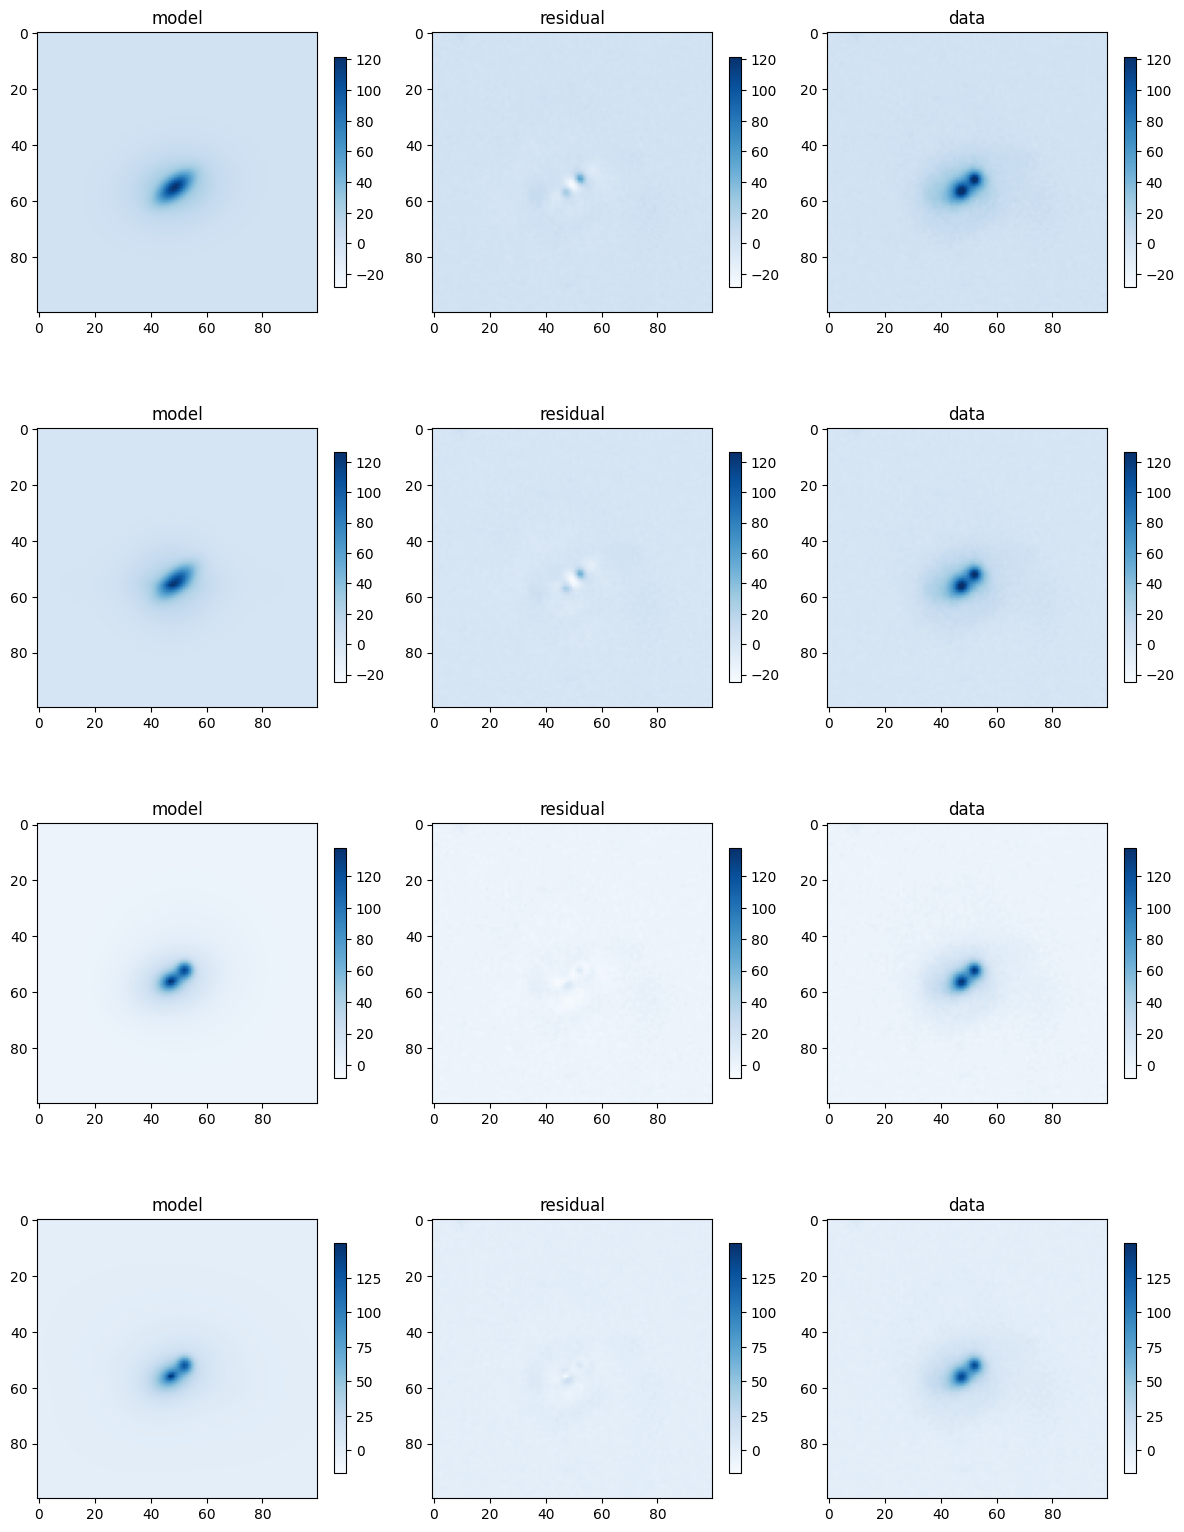

In [48]:
#define some limits
starpos = find_highest_indices(imageAGN)
center = (starpos[0]+starpos[1])/2
Imax = imageAGN.max()
#create galaxy models
model_gs, model_ggs, model_gsgs, model_gsgss = galaxy_model(X0=starpos[0][0], Y0=starpos[0][1], X1=starpos[1][0], Y1=starpos[1][1], Xss=center[0], Yss=center[1],
                                                             Xlim=[0,100], Ylim=[0,100],
                                                             PA0=200, ell0=0.1, I0=Imax-20, sigma0=5, 
                                                             PA1=200, ell1=0.1, I1=Imax-20, sigma1=5,
                                                             PA_ss=200, ell_ss=0.1, n_ss=5, I_ss=1, r_ss=10,
                                                             PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[1,Imax], sigma_lim=[0,15])

# run best fits
models = model_gs, model_ggs, model_gsgs, model_gsgss
fitters, bestfits = doFit(models)
#for emcee later
imfit_fitter_gs,imfit_fitter_ggs,imfit_fitter_gsgs,imfit_fitter_gsgss=fitters
p_bestfit_gs,p_bestfit_ggs,p_bestfit_gsgs,p_bestfit_gsgss = bestfits

# save model and bestfit params
title = ["1 gaussian + sersic", "2 gaussians + 1 sersic", "2 (gausian+sersic)", "2 (gaussian+sersic) + sersic"]
save_config_bestfit(title, models, bestfits,"test2.txt")

# save model and residual figs
plot_bestFit(fitters, imageAGN, title,"test2.jpg")

In [65]:
def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood


def lnPrior_limits( params, imfitter ):
    parameterLimits = imfitter.getParameterLimits()
    if None in parameterLimits:
        raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        ## if param value is outside of the limits set by the model
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0

def run_mcmc(p_bestfit, imfit_fitter):
    ndims, nwalkers = len(p_bestfit), 100
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))

    #inital position around best fit
    initial_pos = [p_bestfit * (1 + 0.0001*np.random.randn(ndims)) for i in range(nwalkers)]
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos, 500)

    #plotting sample

    converged_samples = sampler.chain[:, 200:, :].reshape((-1, ndims))
    print("Number of samples in \"converged\" chain = {0}".format(len(converged_samples)))
    return sampler, converged_samples

    
def PlotAllWalkers(sample_chain, yAxisLabel):
    fig,ax = plt.subplots(ndims,1,figsize=(5,20))
    nWalkers = sample_chain.shape[0]
    for j in range(len(yAxisLabel)):
        for i in range(nWalkers):
            ax[j].plot(sample_chain[i,:,j], color='0.5')
    [ax[i].set_xlabel('Step number') for i in range(len(yAxisLabel))]
    [ax[i].set_ylabel(yAxisLabel[i]) for i in range(len(yAxisLabel))];


In [70]:
sampler, converged_samples = run_mcmc(p_bestfit_gsgs, imfit_fitter_gsgs)

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

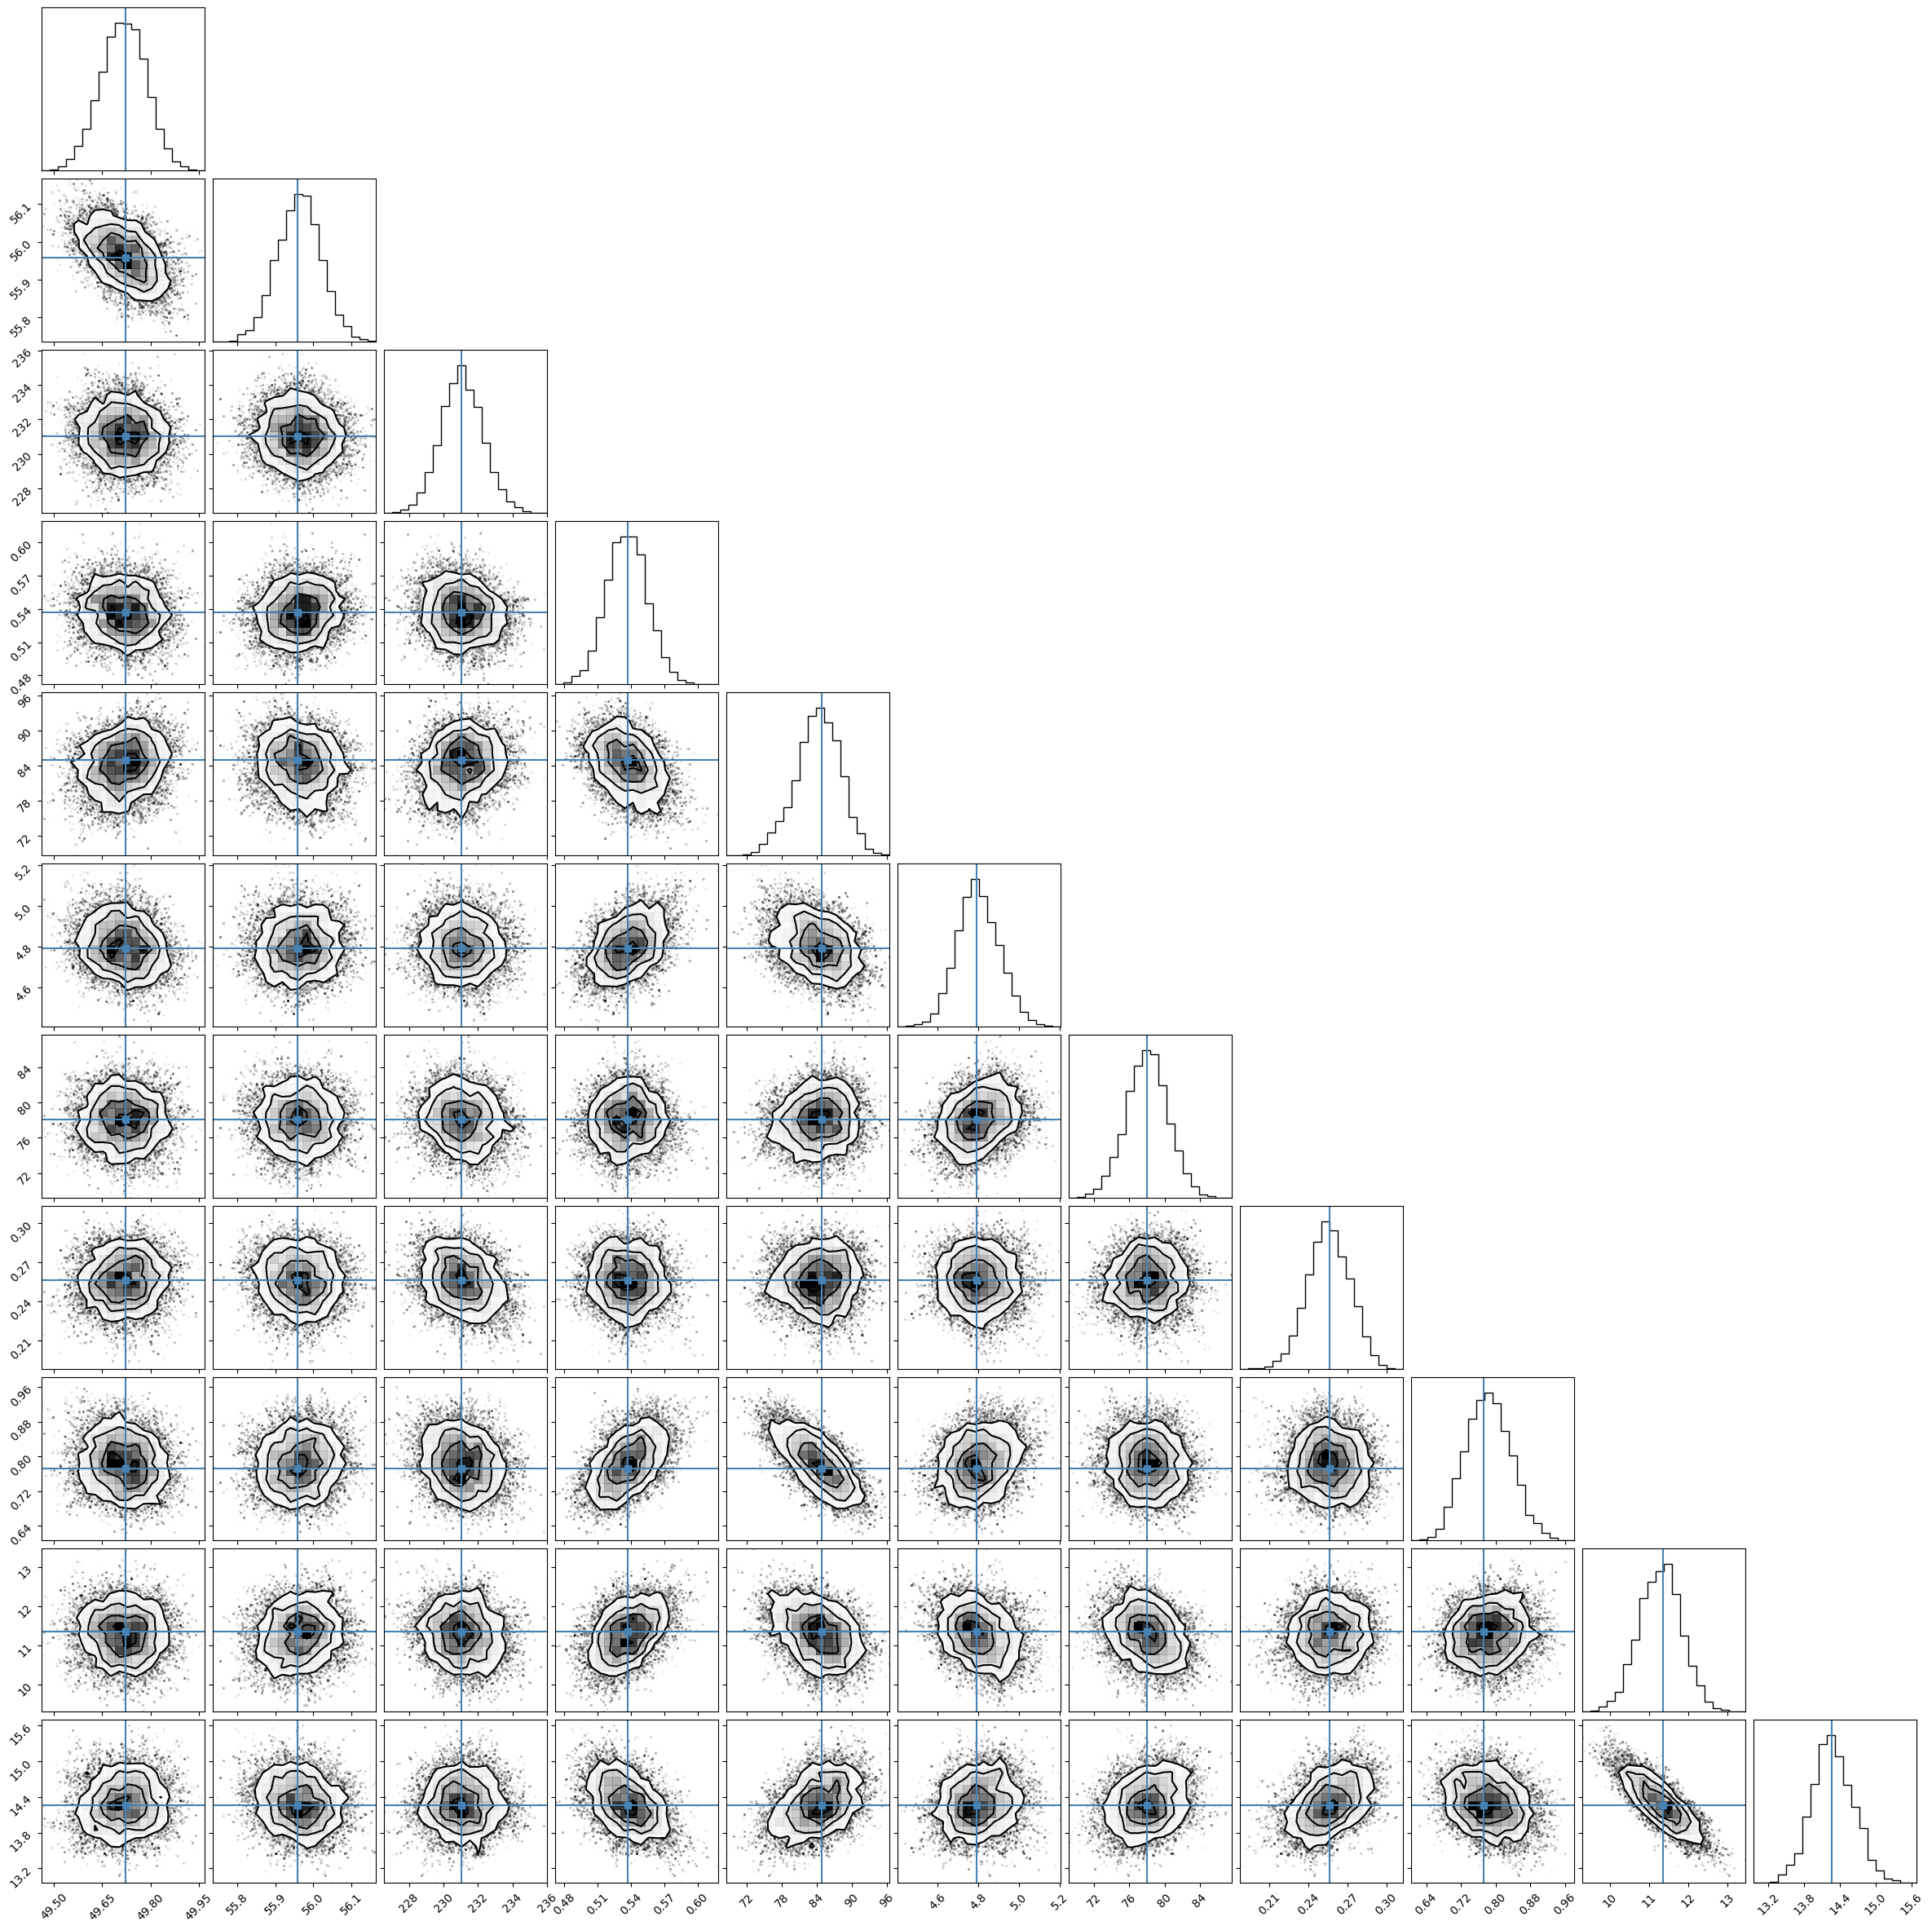

In [68]:
fig = corner.corner(converged_samples, truths=p_bestfit_gs)

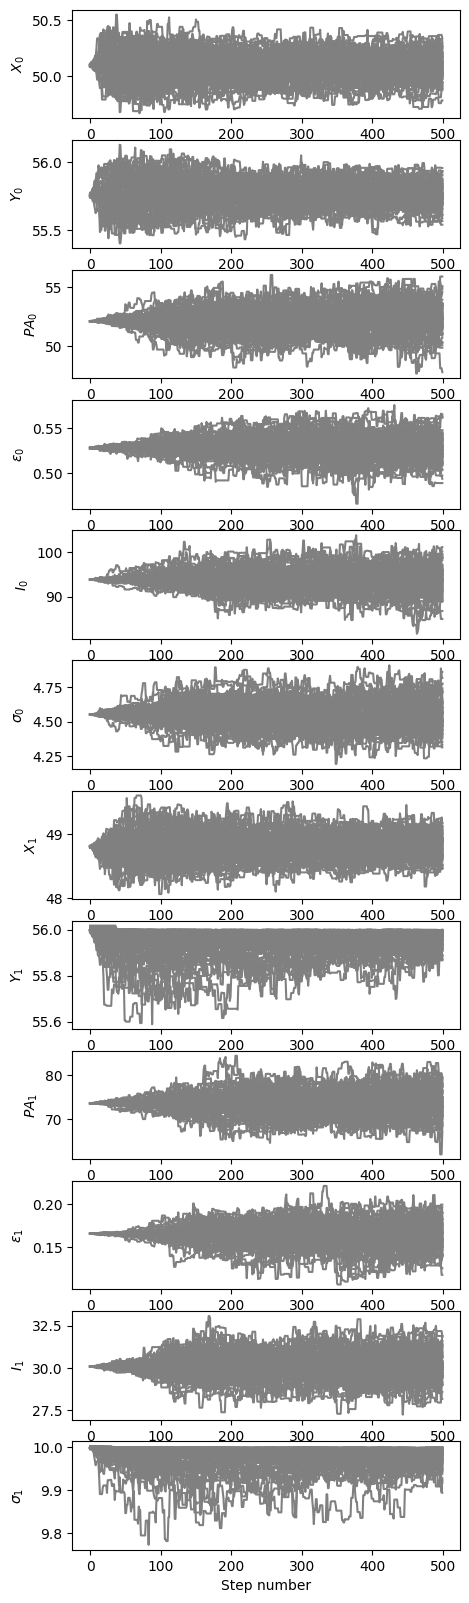

In [107]:

"""
for i in range(ndims):
    mcmc = np.percentile(converged_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = f'{labels[i]} = {mcmc[1]:.3f} $^{{{q[0]:.3f}}}_{{{q[1]:.3f}}}$'
    display(Latex(txt))
"""    
    
PlotAllWalkers(sampler.chain, labels)

In [128]:
ln_likelihood = np.max(sampler.get_log_prob())
n_params = ndims
n_data_points = len(imageAGN.flatten())
bic = -2 * ln_likelihood + n_params * np.log(n_data_points)

print(f"BIC: {bic:.3f}")

BIC: 1371.062
